# Parse EDF and .txt with annotations to a CSV file 

## Methods

In [ ]:
import os
import numpy as np
import pandas as pd
import urllib.request
from datetime import datetime
!pip install mne
import mne

def to_timestamp(x: str, acq_time: datetime):
    date = datetime.strptime(x, '%H:%M:%S')
    date = datetime(acq_time.year, acq_time.month, acq_time.day, date.hour, date.minute, date.second)
    if date.hour < 12:
        date = datetime(date.year, date.month, date.day + 1, date.hour, date.minute, date.second)
    return (date.day - acq_time.day) * 24 * 3600 + (date.hour - acq_time.hour) * 3600 + (
                date.minute - acq_time.minute) * 60 + date.second - acq_time.second


def subsample(data: np.ndarray, fs: int, fs_new: int, axis=0):
    assert fs % fs_new == 0
    factor = int(fs / fs_new)
    if data.shape[axis] % factor != 0:
        print('Subsampling led to loss of %i samples, in an online setting consider using a BlockBuffer with a '
              'buffer size of a multiple of %i samples.' % (data.shape[axis] % factor, factor))
    idx_mask = np.arange(data.shape[axis], step=factor)
    return data.take(idx_mask, axis)


def read_annotation_file(path_filename: str, acq_time: datetime):
    df_annotations_data = pd.read_csv(path_filename, sep='\t', skiprows=20)
    df_annotations_data = df_annotations_data.loc[df_annotations_data["Event"].str.startswith("SLEEP")]
    df_annotations_data = df_annotations_data.rename(columns={"Time [hh:mm:ss]": "onset", "Duration[s]": "duration"})
    df_annotations_data["timestamp"] = df_annotations_data.onset.apply(lambda x: to_timestamp(x, acq_time))

    return df_annotations_data


def merge_data_file_and_annotations(data, df_annotations, fs_new):
    raw_data = data.get_data()
    fs = int(data.info["sfreq"])
    df = pd.DataFrame(raw_data.T, columns=data.info.ch_names)
    df["times"] = data.times
    df = pd.DataFrame(data=subsample(df.to_numpy(), fs, fs_new), columns=df.columns)
    
    labels = [np.nan] * df.shape[0]
    for i in range(df_annotations.shape[0] - 1):
        row_start = df_annotations.iloc[i]
        row_end = df_annotations.iloc[i + 1]
        start_pos = row_start.timestamp * fs_new
        end_pos = row_end.timestamp * fs_new
        if start_pos < len(labels):
            labels[start_pos:end_pos] = [row_start["Sleep Stage"]]*(end_pos-start_pos)
    
    df["sleepstage"] = labels
    df = df.dropna()
    
    return df

     |████████████████████████████████| 6.9MB 16.8MB/s 


## Annotations file

In [ ]:
# Subject ID
subject_name = 'brux2'

# New frequency
fs_new = 128

# CSV Filename
new_filename = f'{subject_name}_data_and_annotations.csv'
              
data_filename = f'{subject_name}.edf'
filename_annotations = f'{subject_name}_annotations.txt'
url_data = f'https://physionet.org/files/capslpdb/1.0.0/{subject_name}.edf?download'
url_annotations = f'https://physionet.org/files/capslpdb/1.0.0/{subject_name}.txt?download'

print(f'Downloading data file: {url_data}')
urllib.request.urlretrieve(url_data, data_filename)

print(f'Downloading annotations data file: {url_annotations}')
urllib.request.urlretrieve(url_annotations, filename_annotations)

print(f'Loading File: {data_filename}')
data_polysomnography = mne.io.read_raw_edf(data_filename)

print(f'Loading Annotations file: {filename_annotations}')
df_annotations_polysomnography = read_annotation_file(filename_annotations, data_polysomnography.info["meas_date"])

print("\n\n Example Annotations file: \n")
df_annotations_polysomnography.head(4)

Loading File: brux2.edf
Extracting EDF parameters from /content/brux2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Loading Annotations file: brux2_annotations.txt


 Example Annotations file: 



,Sleep Stage,Position,onset,Event,duration,Location,timestamp
0,W,Unknown Position,22:08:16,SLEEP-S0,30,ROC-LOC,180
1,W,Unknown Position,22:08:46,SLEEP-S0,30,ROC-LOC,210
2,W,Unknown Position,22:09:16,SLEEP-S0,30,ROC-LOC,240
3,W,Unknown Position,22:09:46,SLEEP-S0,30,ROC-LOC,270


## Merge files + Download

In [ ]:
print(f'Merge files annotation and polysomnography data. Downsampling data from {data_polysomnography.info["sfreq"]} to {fs_new} Hz')
df_data = merge_data_file_and_annotations(data_polysomnography, df_annotations_polysomnography, fs_new)
df_data.to_csv(new_filename, index=False)
print("Data Merged")
df_data.head()

Merge files annotation and polysomnography data. Downsampling data from 256.0 to 128 Hz
Data Merged


,Fp2-F4,F4-C4,C4-P4,P4-O2,F8-T4,T4-T6,FP1-F3,F3-C3,C3-P3,P3-O1,F7-T3,T3-T5,C4-A1,ROC-LOC,EMG1-EMG2,ECG1-ECG2,DX1-DX2,SX1-SX2,times,sleepstage
23040,-2.487790e-06,-0.000007,-0.000008,-0.000007,-0.000008,-0.000007,-5.540293e-06,-5.570818e-06,-0.000006,-2.594628e-07,-0.000008,-0.000003,0.000003,-8.545358e-07,-0.000005,-0.000022,-4.884005e-07,-2.136752e-07,180.000000,W
23041,-1.083639e-06,-0.000006,-0.000009,-0.000012,-0.000009,-0.000016,-3.434066e-06,-4.197192e-06,-0.000007,-7.493895e-06,-0.000007,-0.000009,-0.000008,-5.798636e-07,-0.000002,-0.000020,-3.052503e-07,-4.273504e-07,180.007812,W
23042,3.205128e-07,-0.000004,-0.000009,-0.000016,-0.000008,-0.000022,-1.938339e-06,-1.877289e-06,-0.000007,-1.137057e-05,-0.000007,-0.000011,-0.000015,-2.197378e-06,-0.000002,-0.000017,-1.526252e-07,-1.343101e-06,180.015625,W
23043,4.960317e-06,-0.000001,-0.000006,-0.000015,-0.000006,-0.000019,5.647131e-07,-5.036630e-07,-0.000005,-1.103480e-05,-0.000005,-0.000009,-0.000014,-4.242160e-06,0.000001,-0.000014,5.494505e-07,2.747253e-07,180.023438,W


# Load CSV

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

path = "/content/gdrive/MyDrive/Universidade/ADAR - Projeto 1/Data/brux2_data_and_annotations.csv"
df_data = pd.read_csv(path, sep=',')

# Plot data

## All signals

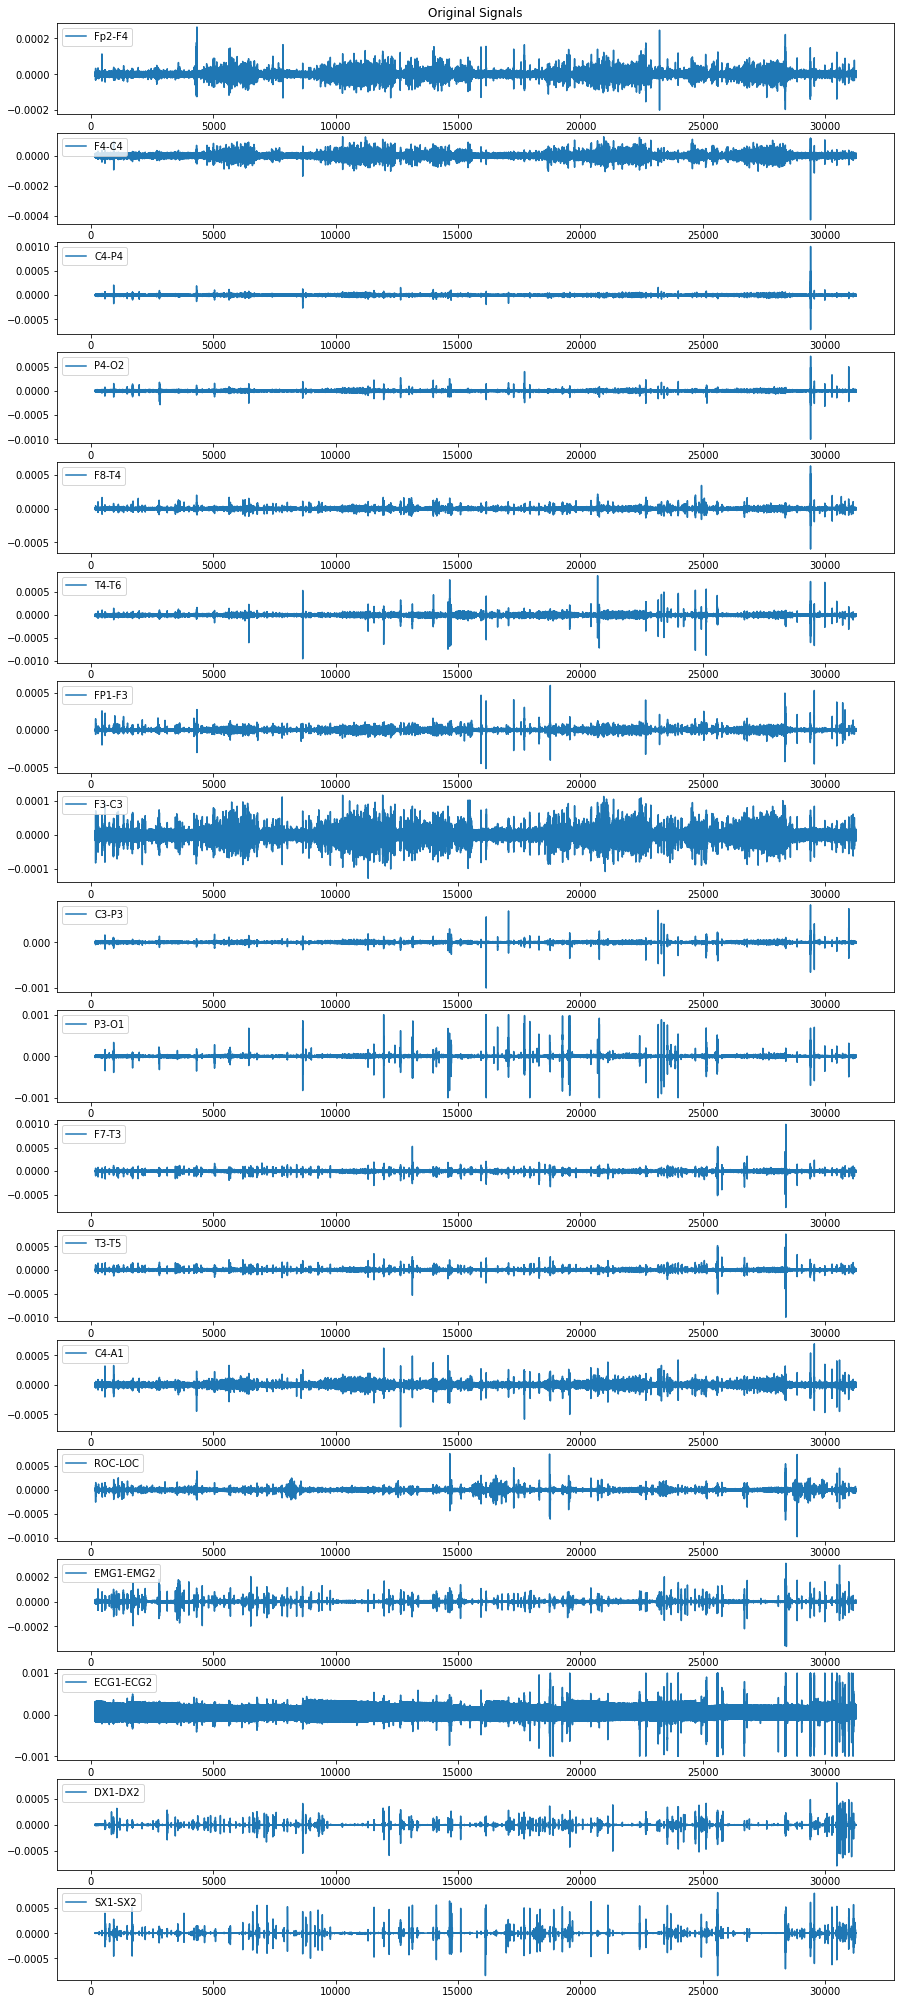

In [12]:
columns_electrodes = [el for el in df_data.columns if el not in ["times", "sleepstage"]]

f, ax = plt.subplots(len(columns_electrodes), 1, figsize=(15, 2*len(columns_electrodes)))
ax[0].set_title("Original Signals")

for i, column_name in enumerate(columns_electrodes):
  ax[i].plot(df_data.iloc[:]["times"], df_data.iloc[:][column_name], label=column_name)
  ax[i].legend(loc='upper left')

## Sleepstage plot

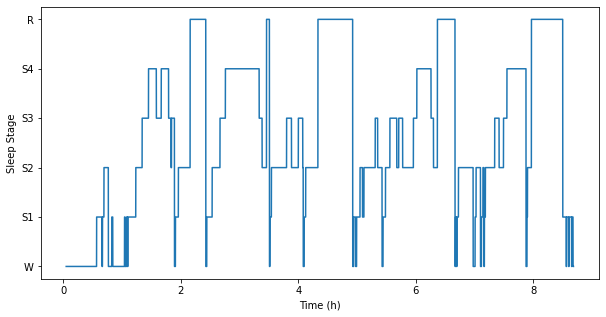

In [15]:
plt.figure(figsize=(10,5))
plt.plot(df_data.times/3600, df_data.sleepstage)
plt.xlabel("Time (h)")
plt.ylabel("Sleep Stage")
plt.show()